In [ ]:
import librosa
import os
import pandas as pd
import glob
import numpy as np
import soundfile
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def extract_feature(file_name,mfcc,chroma,mel,zcr,rmse):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zcr:
            zcr=np.mean(librosa.feature.zero_crossing_rate(y=X, frame_length=2048, hop_length=512).T,axis=0)
            result=np.hstack((result, zcr))
        if rmse:
            rmse=np.mean(librosa.feature.rms(S=stft,frame_length=2048, hop_length=512, pad_mode='reflect').T,axis=0)
            result=np.hstack((result, rmse))
    return result

In [ ]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/drive/MyDrive/EmoDB dataset/*.wav"):
        file_name=os.path.basename(file)
        emotion=file_name[5]
        if emotion=='W':
          e='anger'
        if emotion=='L':
          e='boredom'
        if emotion=='E':
          e='disgust'
        if emotion=='A':
          e='fear'
        if emotion=='F':
          e='happiness'
        if emotion=='T':
          e='sadness'
        if emotion=='N':
          e='neutral'
        feature=extract_feature(file,mfcc=True,chroma=True,mel=True,zcr=True,rmse=True)
        x.append(feature)
        y.append(e)
    return train_test_split(np.array(x), y, test_size=test_size)

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [ ]:
x_train.shape,x_test.shape

((428, 182), (107, 182))

In [ ]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [ ]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(428, 182, 1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 173, 64)           704       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 164, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 11, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)           

In [ ]:
import tensorflow.keras as keras
model_history=model.fit(x_train, y_train,batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
14/14 [==============================] - 3s 125ms/step - loss: 6.0833 - accuracy: 0.1688 - val_loss: 2.6516 - val_accuracy: 0.3458
Epoch 2/100
14/14 [==============================] - 1s 107ms/step - loss: 3.0335 - accuracy: 0.2860 - val_loss: 2.3914 - val_accuracy: 0.4206
Epoch 3/100
14/14 [==============================] - 1s 104ms/step - loss: 2.6121 - accuracy: 0.3050 - val_loss: 2.2169 - val_accuracy: 0.4673
Epoch 4/100
14/14 [==============================] - 1s 105ms/step - loss: 2.4079 - accuracy: 0.4038 - val_loss: 2.0796 - val_accuracy: 0.4766
Epoch 5/100
14/14 [==============================] - 1s 105ms/step - loss: 2.3814 - accuracy: 0.3850 - val_loss: 1.9966 - val_accuracy: 0.5140
Epoch 6/100
14/14 [==============================] - 1s 97ms/step - loss: 2.2531 - accuracy: 0.3971 - val_loss: 1.9548 - val_accuracy: 0.4673
Epoch 7/100
14/14 [==============================] - 1s 97ms/step - loss: 2.1339 - accuracy: 0.4226 - val_loss: 1.8178 - val_accuracy: 0.5421
E

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

4/4 [==============================] - 0s 20ms/step - loss: 1.1989 - accuracy: 0.7290
Loss of the model is -  1.1988840103149414
4/4 [==============================] - 0s 20ms/step - loss: 1.1989 - accuracy: 0.7290
Accuracy of the model is -  72.89719581604004 %


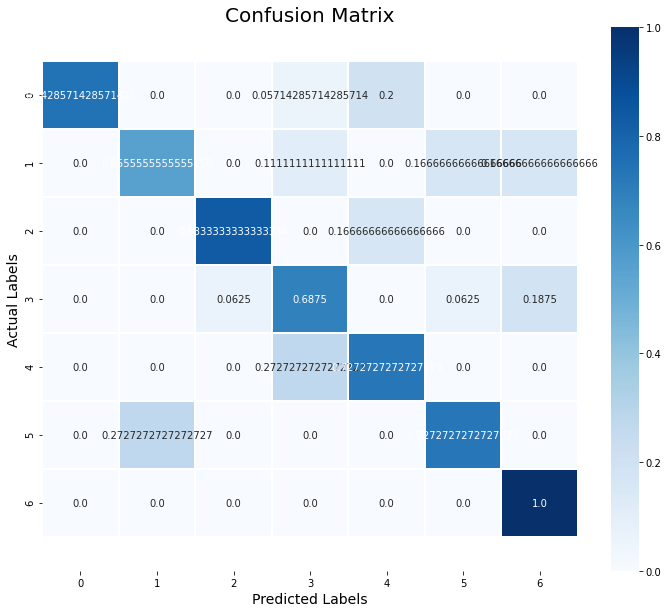

In [ ]:
predictions = model.predict(x_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
cm = confusion_matrix(actual, predictions,normalize='true')
plt.figure(figsize = (12, 10))
conf_matrix= pd.DataFrame(cm,columns=None)
conf_matrix.to_csv(r'E:\confusion_matrix.csv', index = False, header=False)
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['anger','boredom','disgust','fear','happiness','neutral','sadness']))

              precision    recall  f1-score   support

       anger       1.00      0.74      0.85        35
     boredom       0.77      0.56      0.65        18
     disgust       0.83      0.83      0.83         6
        fear       0.61      0.69      0.65        16
   happiness       0.50      0.73      0.59        11
     neutral       0.67      0.73      0.70        11
     sadness       0.62      1.00      0.77        10

    accuracy                           0.73       107
   macro avg       0.72      0.75      0.72       107
weighted avg       0.77      0.73      0.74       107



In [ ]:
from imblearn.metrics import specificity_score
s=specificity_score(actual,predictions,average='macro')
print(s)

0.9560874853866117


In [ ]:
from sklearn.metrics import roc_auc_score
y_score=model.predict(x_test)
auc=roc_auc_score(y_test, y_score, average='macro',multi_class='ovo')
print(auc)

0.9079099078994622


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
p=precision_score(actual,predictions,average='macro')
r=recall_score(actual,predictions,average='macro')
f=f1_score(actual,predictions,average='macro')
print(p,r,f)

0.7150488400488401 0.7533987837559266 0.7193554284735962


In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)

[0.74285714 0.55555556 0.83333333 0.6875     0.72727273 0.72727273
 1.        ]
[0.         0.04545455 0.01041667 0.07349687 0.06111111 0.03819444
 0.05902778]


In [ ]:
l=[]
for i in range(100):
  l.append(i+1)

In [ ]:
from pandas import DataFrame
C = {'epoch no':l,
    'acc train':model_history.history['accuracy'],
    'acc val':model_history.history['val_accuracy'],
    'loss train':model_history.history['loss'],
    'loss val':model_history.history['val_loss']}
df = DataFrame(C, columns= ['epoch no','acc train','acc val','loss train','loss val'])
export_csv = df.to_csv (r'E:\result1.csv', index = None, header=True) 
print (df)

    epoch no  acc train   acc val  loss train  loss val
0          1   0.172897  0.345794    4.987357  2.651602
1          2   0.273364  0.420561    2.935440  2.391357
2          3   0.306075  0.467290    2.588524  2.216855
3          4   0.371495  0.476636    2.417942  2.079623
4          5   0.399533  0.514019    2.343622  1.996581
..       ...        ...       ...         ...       ...
95        96   0.841121  0.691589    0.703389  1.194717
96        97   0.852804  0.738318    0.562986  1.064500
97        98   0.887850  0.766355    0.521043  1.040353
98        99   0.864486  0.794393    0.553416  1.108786
99       100   0.878505  0.728972    0.520604  1.198884

[100 rows x 5 columns]


In [ ]:
from pandas import DataFrame
C = {
     'train acc':[str(model_history.history['accuracy'][99])],
     'test acc':[str(model_history.history['val_accuracy'][99])],
     'precision(macro)':[str(p)],
     'recall(macro)':[str(r)],
     'f1(macro)':[str(f)],
     'specificity(macro)':[str(s)],
     'AUC(macro)':[str(auc)],
     'train time per epoch':['1 sec'],
     'test time per epoch':['1 sec'],}
df = DataFrame(C, columns= ['train acc','test acc','precision(macro)','recall(macro)','f1(macro)','specificity(macro)','AUC(macro)','train time per epoch','test time per epoch'])
export_csv = df.to_csv (r'E:\result2.csv', index = None, header=True) 
print (df)

            train acc  ... test time per epoch
0  0.8785046935081482  ...               1 sec

[1 rows x 9 columns]


In [ ]:
from pandas import DataFrame
C = {
     'TPR': TPR,
     'FPR': FPR}
df = DataFrame(C, columns= ['TPR','FPR'])
export_csv = df.to_csv (r'E:\result3.csv', index = None, header=True) 
print (df)

        TPR       FPR
0  0.742857  0.000000
1  0.555556  0.045455
2  0.833333  0.010417
3  0.687500  0.073497
4  0.727273  0.061111
5  0.727273  0.038194
6  1.000000  0.059028
